In [1]:
import sys
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append('../../')

import numpy as np
import random
from IPython.display import Image

import torch
from torch.utils.data import DataLoader

from torchvision.datasets.mnist import MNIST

from utils import show_first_batch, transform_data, show_images, plot_metrics_iddpm, show_tensor_images
from train import Trainer
from diffusion_models.iddpm import GaussianDiffusion
from metrics.fid_score import fid_score
from metrics.inception_score import inception_score
from diffusion_models.iddpm import Classifier, classifier_cond_fn

from reverse_models.iunet.unet import Unet

import ipywidgets as widgets
widgets.IntSlider()

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

training complete


device(type='cuda')

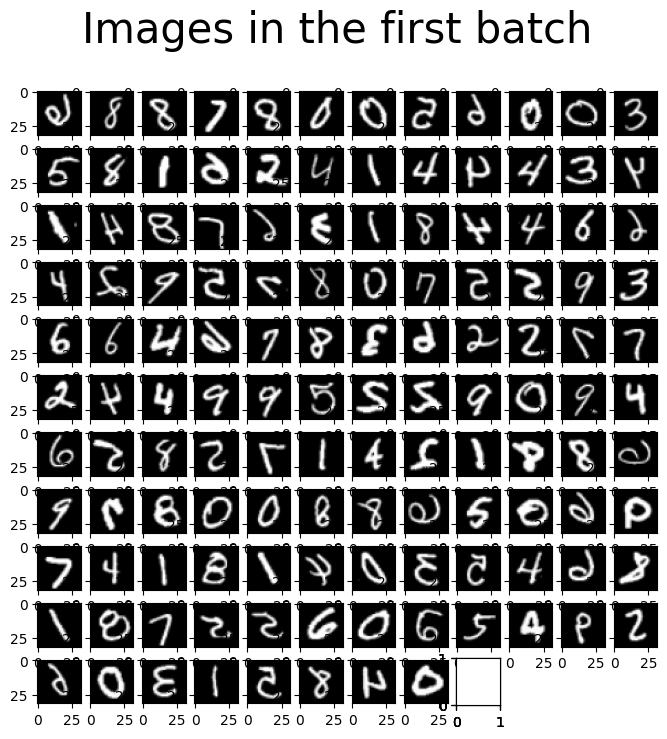

In [2]:
dataset = transform_data(MNIST, store_path="../../datasets")
train_dataloader = DataLoader(dataset, batch_size=128, num_workers=0, shuffle=True)
show_first_batch(train_dataloader)

In [3]:
model = Unet(dim = 16, channels=1).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,
    timesteps = 1000,  
    beta_schedule='cosine',
    loss_type = 'l1'           
).to(device)

In [14]:
trainer = Trainer(
    diffusion,
    train_dataloader,
    train_lr = 1e-5,
    train_num_steps = 700000, 
    device=device
) 

In [15]:
trainer.train()

loss: 0.0968:   2%|▏         | 11155/700000 [33:36<34:35:29,  5.53it/s]


KeyboardInterrupt: 

In [16]:
store_path = '../../model_weights/iddpm_mnist_steps_1000.pt'

torch.save(diffusion.state_dict(), store_path)

In [14]:
model = Unet(dim = 16, channels=1).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = 32,
    timesteps = 1000, 
    beta_schedule='cosine',
    loss_type = 'l1'           
).to(device)

In [15]:
diffusion.load_state_dict(torch.load(store_path, map_location=device))
diffusion.eval()
print("Model loaded")

Model loaded


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

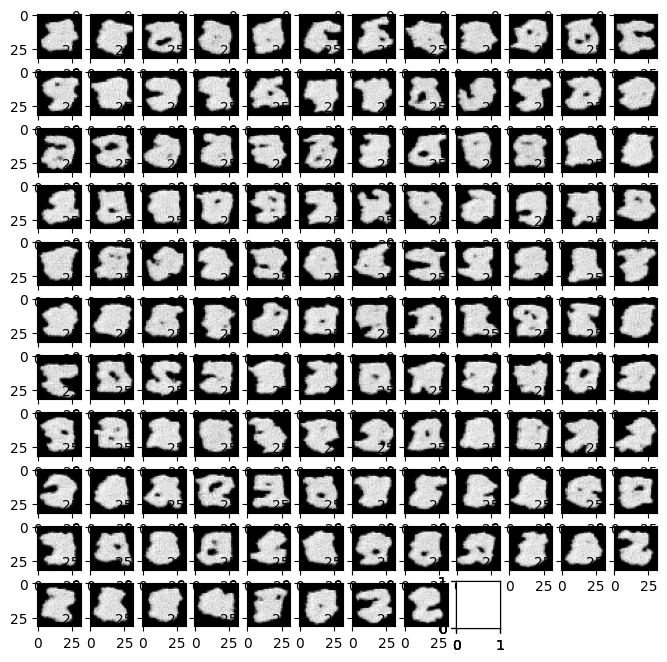

In [17]:
classifier = Classifier(image_size=32, num_classes=10, n_channels=1, t_dim=1).to(device)

generated_images = diffusion.sample(
        batch_size = 128,
        cond_fn=classifier_cond_fn, 
        guidance_kwargs={
            "classifier":classifier,
            "y": torch.fill(torch.zeros(128), 1).long(),
            "classifier_scale": 0.8,
        }
    ).cpu()

show_images(generated_images)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

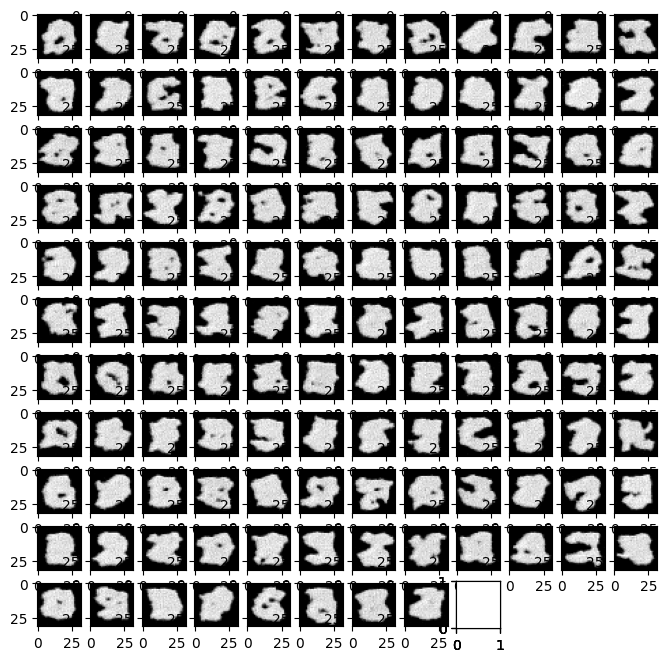

In [18]:
generated_images = diffusion.sample(batch_size = 128).cpu()
show_images(generated_images)